In [62]:
from torchvision import transforms  # type: ignore
from PIL import Image
from skimage import exposure
from torchvision import datasets, transforms  # type: ignore
from torch.utils.data import DataLoader

def clahe(x: torch.Tensor):
    x = x.numpy()
    x = exposure.equalize_adapthist(x)
    x = torch.from_numpy(x)
    return x

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (0.299 * x[0] + 0.587 * x[1] + 0.114 * x[2]).unsqueeze(0)),
])

In [63]:
from model.hvae import HVAE
import torch

vae_model = HVAE(
    initial_image_size=128,
    input_channels=1,
    output_channels=1,
    encoder_hidden_dims=[32] + [64, 128],
    latent_dims=[64],
    learning_rate=1e-4,
    beta=2,
    stride=2,
)

for param in vae_model.parameters():
    param.requires_grad = False

vae_model.load_state_dict(
    torch.load(
        f'im_128_enc_32_64_128_lat_64_beta_2.ckpt'
    )['state_dict']
)

Encoder:
	1 -> 32, stride=1
	32 -> 64, stride=2
	64 -> 128, stride=2
LatentSpace:
	131072 (flattened) -> 64
Decoder input:
	64 -> 131072 (flattened)
Decoder:
	128 -> 64, stride=2
	64 -> 32, stride=2
	32 -> 1, stride=1
weights_sum / before_weights_sum: 0.912322998046875


<All keys matched successfully>

In [64]:
def read_image(img_path = "SMDG-19/val/1/G1020-1008.png"): 
    img = Image.open(img_path)
    img = val_transform(img).unsqueeze(0)
    return img

In [65]:
def encode_image(img: torch.Tensor): 
    embd = vae_model.encoder(img)
    mus, logvars = vae_model.latent_space(embd)
    mu = mus[-1][0]
    logvar = logvars[-1][0]
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu, logvar, eps, std

In [66]:
img = read_image()
mu, logvar, eps, std = encode_image(img)

imgs = []
for pos in range(len(eps)): 
    for new_c in [-10, -5, 0, 5, 10]:
        eps_cp = eps.clone().detach()
        eps_cp[pos] = new_c
        z = mu + std * eps_cp
        img = vae_model.decoder(z)
        imgs.append(img)

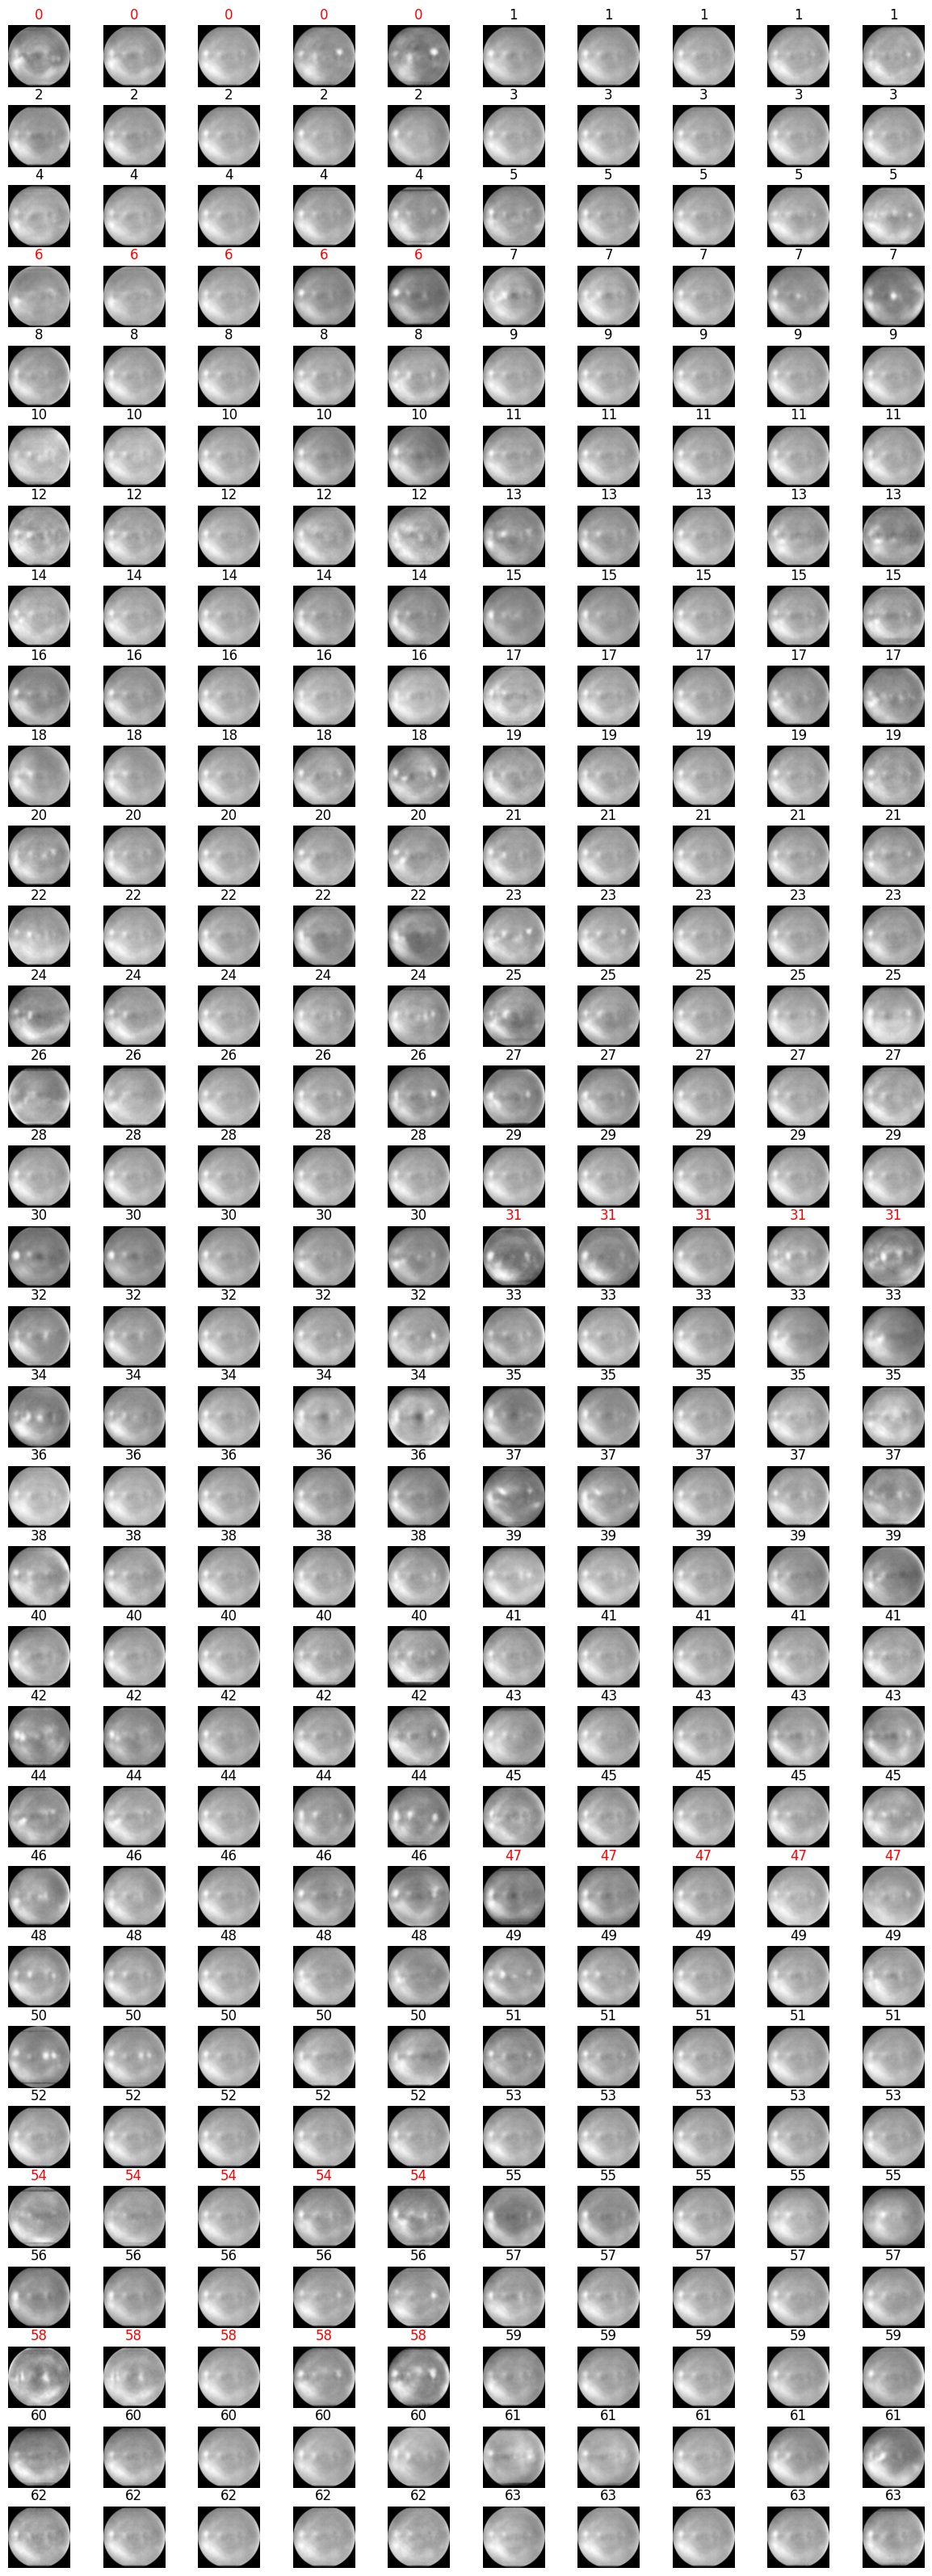

In [67]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(imgs) // 10, ncols=10, figsize=(12, len(imgs) // 10))

axes = axes.flatten()
red_border_indices = [0, 6, 31, 47, 54, 58]

for i, ax in enumerate(axes):
    ax.imshow(imgs[i].squeeze(), cmap='gray')
    ax.axis('off')

    if i // 5 in red_border_indices:
        ax.set_title(f'{i // 5}', color='red')
    else:
        ax.set_title(f'{i // 5}')

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.3)
plt.show()

### Some explanation

What it seems: 
- `idx = 0` - probably a light artifact (visible in some of the photos) next to the pupil
- `idx = 6` - brightness and position of the pupil on the left side
- `idx = 31` - maybe overall "brightness" of the image
- `idx = 47` - how "cut" is the image on the lower part
- `idx = 54` - how "cut" is the image on the upper part
- `idx = 58` - it looks like a distribution of the artifacts of the eye (not the pupil and nerves) that were visible in some of the photos

In [68]:
import os
import random

test_files_0 = os.listdir(f"./SMDG-19/test/0")
test_files_0 = [f"0/{f}" for f in test_files_0]

test_files_1 = os.listdir(f"./SMDG-19/test/1")
test_files_1 = [f"1/{f}" for f in test_files_1]

test_files = test_files_0 + test_files_1
random.shuffle(test_files)

test_files = test_files[:5]
mult_imgs = []
changed_idxs = []
img_idxs = []

for pos in red_border_indices:
    for test_file in test_files:
        img = read_image(os.path.join("SMDG-19/test/", test_file))
        mu, logvar, eps, std = encode_image(img)

        for new_c in [-10, 10]:
            eps_cp = eps.clone().detach()
            eps_cp[pos] = new_c
            z = mu + std * eps_cp
            img = vae_model.decoder(z)
            mult_imgs.append(img)
            changed_idxs.append(pos)
            img_idxs.append(test_file)


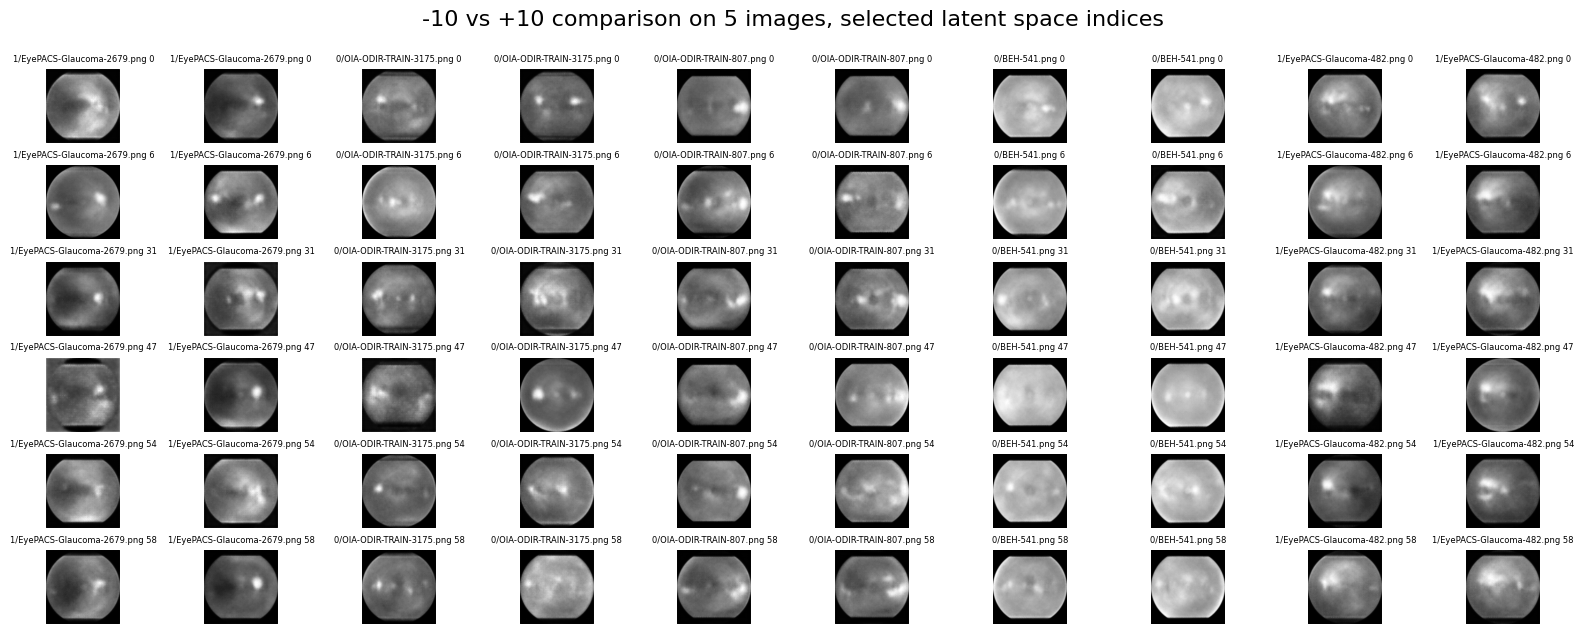

In [69]:
fig, axes = plt.subplots(nrows=len(mult_imgs) // 10, ncols=10, figsize=(16, len(mult_imgs) // 10))

axes = axes.flatten()
red_border_indices = [0, 6, 31, 47, 54, 58]

for i, ax in enumerate(axes):
    ax.imshow(mult_imgs[i].squeeze(), cmap='gray')
    ax.axis('off')

    img_idx = img_idxs[i]
    changed_idx = changed_idxs[i]

    ax.set_title(f'{img_idx} {changed_idx}', fontsize=6)

fig.tight_layout()
# title
fig.suptitle('-10 vs +10 comparison on 5 images, selected latent space indices', fontsize=16, y=1.05)
fig.subplots_adjust(wspace=0.05, hspace=0.3)
plt.show()

What is good, there are some actual differences visible!